<br><br>

## Connecting to the Database

---

In [1]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import oracledb
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import RidgeCV 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

In [2]:
# Connecting to the database
dsn = oracledb.makedsn("localhost", 1522, service_name="stu")
connection = oracledb.connect(user="ora_msan99", password="a85263259", dsn=dsn)

In [3]:
# Extract data from the database tables 
Province=[]
cur = connection.cursor()
for row in cur.execute("select * from Province"):
    Province.append(row)
cur.close()

Industry=[]
cur = connection.cursor()
for row in cur.execute("select * from Industry"):
    Industry.append(row)  
cur.close()

IndustryMapping=[]
cur = connection.cursor()
for row in cur.execute("select * from IndustryMapping"):
    IndustryMapping.append(row)    
cur.close()

Emissions=[]
cur = connection.cursor()
for row in cur.execute("select * from Emissions"):
    Emissions.append(row)   
cur.close()


In [4]:
# Store the data from the database as dataframes 
emissions = pd.DataFrame(Emissions,columns=['province','IndustryName', 'IOIC', 'year',  'emissions', 'industry_code'])

industry = pd.DataFrame(IndustryMapping,columns=['IndustryCode', 'IndustryName', 'NAICS', 'IOIC', 'Durable'])

population = pd.DataFrame(Province,columns=['province', 'year', 'Population'])

employment = pd.DataFrame(Industry,columns=['Good_Type', 'province', 'year','No_Employed'])

<br><br>

## Tidying the Data

---

In [5]:
# TIDY THE EMISSIONS DATASET AND CALCULATE EMISSIONS PER INDUSTRY TYPE
# join emissions and industry together
emissions_industry = pd.merge(emissions, industry, left_on="industry_code", right_on="IndustryCode")

# filter out canada in the emissions_industry dataset
emissions_industry = emissions_industry[emissions_industry["province"] != "Canada"]

# drop duplicate columns
emissions_industry = emissions_industry[['province','year','emissions','industry_code','Durable']]

# create a new column called ProvinceYearDurable in EmissionsIndustry
emissions_industry["ProvinceYearDurable"] = emissions_industry["province"] + emissions_industry["year"].astype(str) + emissions_industry["Durable"].astype(str)

# remove households, put in separate dataframe
emissions_household = emissions_industry[emissions_industry["industry_code"].isin(['99999', '99998'])]
emissions_industry = emissions_industry[~emissions_industry["industry_code"].isin(['99999', '99998'])]

emissions_household_tidy = emissions_household.drop(columns=["industry_code"])

# group by Province and Year to calculate the total  emissions for each household 
grouped_emissions_hh = pd.DataFrame(emissions_household_tidy.groupby(['province', 'year'])['emissions'].sum())
grouped_emissions_hh = grouped_emissions_hh.reset_index()
grouped_emissions_hh["ProvinceYear"] = grouped_emissions_hh["province"] + grouped_emissions_hh["year"].astype(str)

# group by Province, Year, and Durable to calculate the total emissions for each good type
grouped_emissions = pd.DataFrame(emissions_industry.groupby(['province', 'year', 'Durable'])['emissions'].sum())
grouped_emissions = grouped_emissions.reset_index()
grouped_emissions["ProvinceYearDurable"] = grouped_emissions["province"] + grouped_emissions["year"].astype(str) + grouped_emissions["Durable"].astype(str)

<br>

In [6]:
# TIDY THE EMPLOYMENT DATASET AND CALCULATE EMISSIONS PER EMPLOYEE 
# remove rows where Good_Type = Manufacturing or province = Canada 
employment_reduced = employment[~((employment["Good_Type"] == "Manufacturing") | (employment["province"] == "Canada"))]

# create a binary variable from Good_Type
durable_mapping = {'Durables': 1, 'Non-durables': 0}

# define a function to assign durable values based on Good_Type
def assign_durable(row):
  good_type_value = row['Good_Type']
  return durable_mapping.get(good_type_value, -1)  # Assign -1 for missing values (optional)

# create a new DataFrame with desired columns and apply function
employment_tidy = employment_reduced[['province', 'year', 'No_Employed']].assign(durable=employment.apply(assign_durable, axis=1))

# create a new column called ProvinceYearDurable in employment_tidy
employment_tidy["ProvinceYearDurable"] = employment_tidy["province"] + employment_tidy["year"].astype(str) + employment_tidy["durable"].astype(str)

# join the grouped_emissions with employment_tidy, drop column used to merge the dataframes
emissions_industry_employment = pd.merge(grouped_emissions, employment_tidy, on="ProvinceYearDurable")
emissions_industry_employment = emissions_industry_employment.drop(columns="ProvinceYearDurable")

# rename and drop duplicate columns 
emissions_industry_employment.drop(columns=["province_y", "year_y", "durable"], inplace=True)
emissions_industry_employment.rename(columns={'province_x': 'province', 'year_x': 'year','Durable': 'durable', 'No_Employed': 'no_employed'}, inplace=True)

# calculate the emissions per employee by dividing emissions by No_Employed 
# No_Employed will first be multiplied by 1000 as the current data is scaled down by 1000
emissions_industry_employment["no_employed_rescaled"] = emissions_industry_employment["no_employed"] * 1000
emissions_industry_employment["emissions_per_employee"] = emissions_industry_employment["emissions"]/emissions_industry_employment["no_employed_rescaled"]

<br>

In [7]:
# TIDY THE POPULATION DATASET AND CALCULATE EMISSIONS PER CAPITA FOR HOUSEHOLDS
# remove rows where province is Canada 
population_reduced = population[population['province'] != "Canada"]
population_reduced.head()

# make a Province Year key
population_reduced["ProvinceYear"] = population_reduced["province"] + population_reduced["year"].astype(str)

# join  grouped_emissions_hh with population_reduced 
emissions_household_population = pd.merge(grouped_emissions_hh, population_reduced, on="ProvinceYear")

# rename and drop duplicate columns
emissions_household_population.drop(columns=["ProvinceYear","province_y", "year_y"], inplace=True) 
emissions_household_population.rename(columns={'province_x': 'province', 'year_x': 'year', 'Population': 'population'}, inplace=True)

# calculate the emissions per capita by dividing emissions by population 
emissions_household_population["emissions_per_capita"] = emissions_household_population["emissions"]/emissions_household_population["population"]

/var/folders/1x/18g3rdbx5rz1sbzhnp6ywcvr0000gn/T/ipykernel_42897/1247162100.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_reduced["ProvinceYear"] = population_reduced["province"] + population_reduced["year"].astype(str)


<br><br>

## Creating the Linear Regression Models

---

In this section, we will create two linear regression models. For both models we will:
- split the related dataset into 70% training and 30% testing data.
- apply one hot encoding to categorical variables.
- use a Ridge linear model
- hypertune the values of alpha for Ridge

<br>

### Model 1: 
- This model will help us investigate how greenhouse gas emissions produced by durable and non-durable industries have changed between 2012 and 2021.

In [8]:
# convert columns to categorical variables 
emissions_industry_employment['province'] = pd.Categorical(emissions_industry_employment['province'])   
emissions_industry_employment['year'] = pd.Categorical(emissions_industry_employment['year'])   
emissions_industry_employment['durable'] = pd.Categorical(emissions_industry_employment['durable'])   
# print(emissions_industry_employment.dtypes)

# identify the independent variables 
X = emissions_industry_employment[['province', 'year', 'durable']]

# Split data into training and testing sets 
industry_X_train, industry_X_test, industry_y_train, industry_y_test = train_test_split(X, emissions_industry_employment['emissions_per_employee'], 
                                                                                        test_size=0.3, random_state=42)

In [9]:
# apply one hot encoding to the categorical independent variables 
categorical_feats = ["province", "year", "durable"] 

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False))

preprocessor = make_column_transformer(
    (categorical_transformer, categorical_feats))

In [10]:
alphas = 10.0 ** np.arange(-6, 6, 1)

# Calling fit to examine all the transformers.
preprocessor.fit(industry_X_train)    
lr = make_pipeline(preprocessor, RidgeCV(alphas=alphas, cv=10))
lr.fit(industry_X_train, industry_y_train);
lr_preds = lr.predict(industry_X_test)

# Append the predictions and actual values as a new column to the original DataFrame  
industry_X_test['predicted_emissions'] = lr_preds
industry_X_test['actual_emissions'] = industry_y_test

In [12]:
# calculate evaluation metrics
m1_mse = mean_squared_error(industry_y_test, lr_preds)
m1_r2 = r2_score(industry_y_test, lr_preds)

# store metrics in a dataframe 
data = [{"model": "Model 1", "mse": m1_mse, "r2": m1_r2}]
model_metrics = pd.DataFrame(data)

model_metrics

,model,mse,r2
0,Model 1,0.007098,0.49652


<br>

### Model 2: 
- This model will help us investigate how greenhouse gas emissions produced by households have changed between 2012 and 2021.

In [13]:
# convert columns to categorical variables 
emissions_household_population['province'] = pd.Categorical(emissions_household_population['province'])   
emissions_household_population['year'] = pd.Categorical(emissions_household_population['year'])   
# print(emissions_household_population.dtypes)

# identify the independent variables 
X = emissions_household_population[['province', 'year']]

# Split data into training and testing sets 
household_X_train, household_X_test, household_y_train, household_y_test = train_test_split(X, emissions_household_population['emissions_per_capita'], 
                                                                                        test_size=0.3, random_state=42)

In [14]:
# apply one hot encoding to the categorical independent variables 
categorical_feats_hh = ["province", "year"] 

categorical_transformer_hh = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False))

preprocessor_hh = make_column_transformer(
    (categorical_transformer_hh, categorical_feats_hh))

In [15]:
alphas_hh = 10.0 ** np.arange(-6, 6, 1)

# Calling fit to examine all the transformers.
preprocessor_hh.fit(household_X_train)    
lr_hh = make_pipeline(preprocessor_hh, RidgeCV(alphas=alphas_hh, cv=10))
lr_hh.fit(household_X_train, household_y_train);
lr_hh_preds = lr_hh.predict(household_X_test)

# Append the predictions and actual values as a new column to the original DataFrame  
household_X_test['predicted_emissions'] = lr_hh_preds
household_X_test['actual_emissions'] = household_y_test

In [25]:
# calculate evaluation metrics
m2_mse = mean_squared_error(household_y_test, lr_hh_preds)
m2_r2 = r2_score(household_y_test, lr_hh_preds)

# store model 2 metrics in the dataframe 
m2_data = {"model": "Model 2", "mse": m2_mse, "r2": m2_r2}
model_metrics = pd.concat([model_metrics, pd.DataFrame([m2_data])], ignore_index=True)
model_metrics

,model,mse,r2
0,Model 1,7.098481e-03,0.496520
1,Model 2,1.443276e-07,0.905178


<br><br>

## Visualizing the Data

---

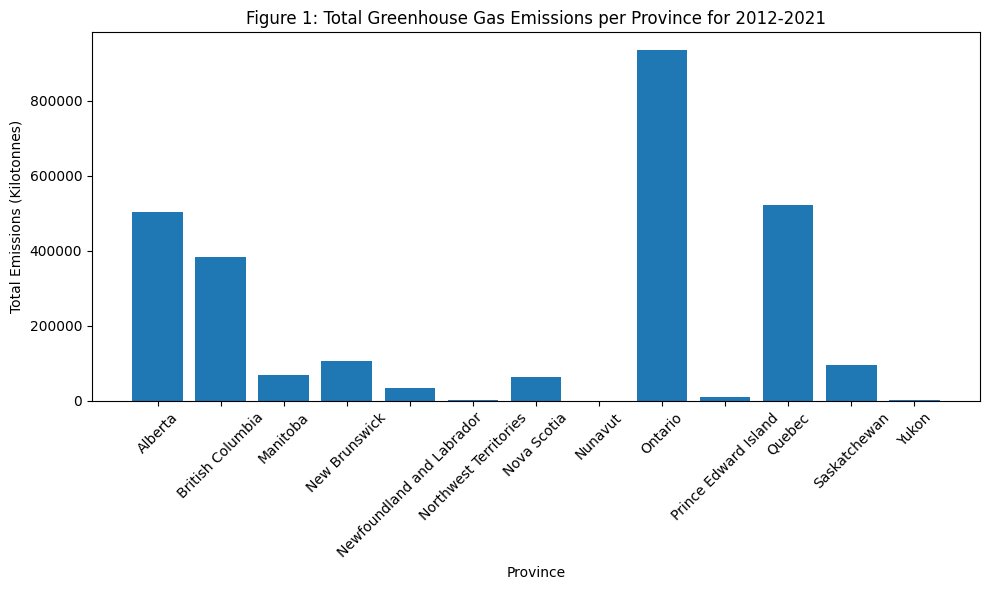

In [74]:
merged_df = pd.merge(emissions, population, on=['province', 'year'])
merged_df_no_can = merged_df[merged_df['province'] != 'Canada']
total_province_emissions = merged_df_no_can.groupby('province')['emissions'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(total_province_emissions['province'], total_province_emissions['emissions'])
plt.title('Figure 1: Total Greenhouse Gas Emissions per Province for 2012-2021')
plt.xlabel('Province')
plt.ylabel('Total Emissions (Kilotonnes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<br>

**Figure 1** shows us the total emissions, from both industries and households, for all provinces between the years 2012 and 2021. We can see that overall, Ontario produced the most emissions, followed by Quebec and Alberta. Smaller provinces like Yukon had substantially less emissions than the rest.

<br><br>

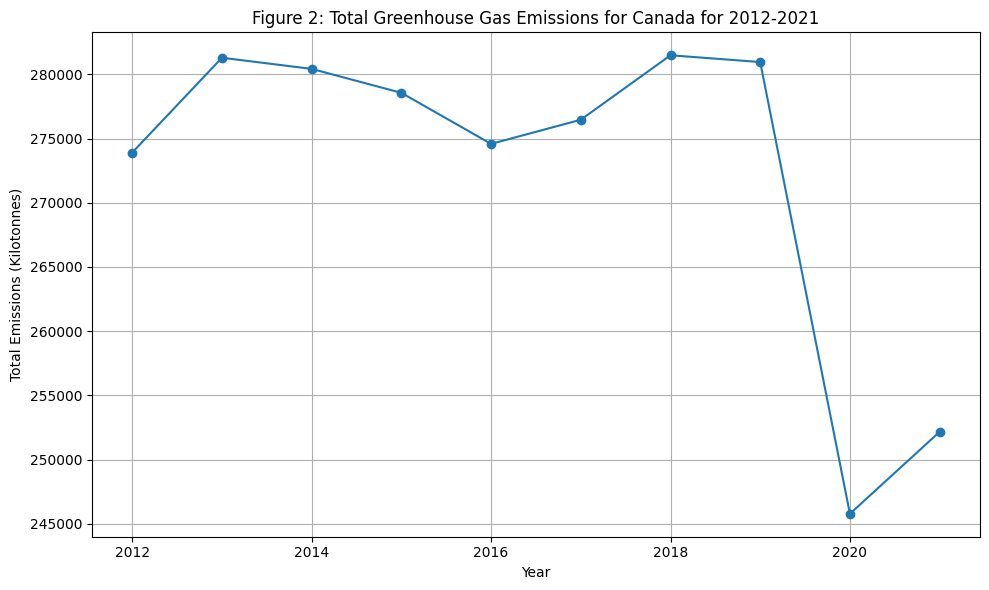

In [46]:
# Merge emissions and province data
canada_emissions = merged_df[merged_df['province'] == 'Canada']

# Group by year and sum emissions for Canada
canada_emissions_over_time = canada_emissions.groupby('year')['emissions'].sum().reset_index()

# Plot emissions over time for Canada
plt.figure(figsize=(10, 6))
plt.plot(canada_emissions_over_time['year'], canada_emissions_over_time['emissions'], marker='o')
plt.title('Figure 2: Total Greenhouse Gas Emissions for Canada for 2012-2021')
plt.xlabel('Year')
plt.ylabel('Total Emissions (Kilotonnes)')
plt.grid(True)
plt.tight_layout()
plt.show()

<br>

**Figure 2** shows us the general trend across Canada for greenhouse gas emissions between 2012 and 2021. There is a notable downturn in emissions between 2018 and 2020, likely corresponding to the effects of the COVID-19 pandemic and lockdown. 

<br><br>

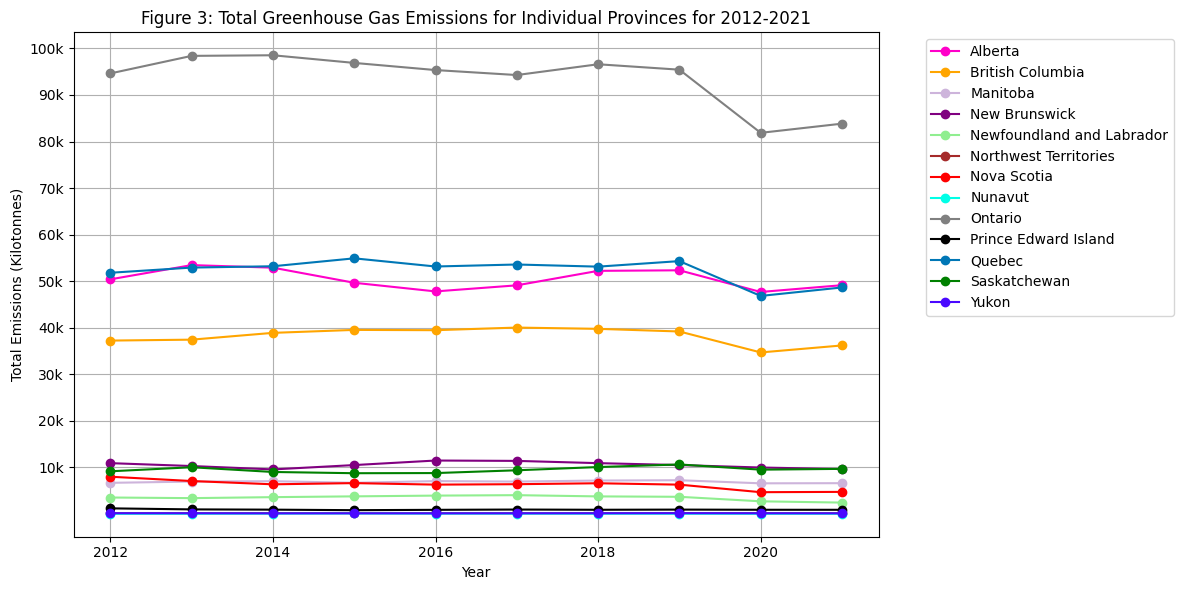

In [75]:
provinces_emissions = merged_df[merged_df['province'] != 'Canada']
provinces_emissions_over_time = provinces_emissions.groupby(['province', 'year'])['emissions'].sum().reset_index()

colors = ['#ff00c9', 'orange', '#CDB4DB', 'purple', 'lightgreen', 'brown', 'red', '#00ffe7', 'grey', 'black', '#0077b6', 'green','#4a08ff']   
y_ticks = [10000, 20000, 30000, 40000, 50000,60000, 70000, 80000, 90000, 100000]  

# Define a counter to keep track of the color index
color_counter = 0

# Plot emissions over time for all provinces
plt.figure(figsize=(12, 6))
for province in provinces_emissions_over_time['province'].unique():
    province_data = provinces_emissions_over_time[provinces_emissions_over_time['province'] == province]
    plt.plot(province_data['year'], province_data['emissions'], marker='o', label=province, color=colors[color_counter % len(colors)])
    # Increment the counter for the next line
    color_counter += 1

plt.title('Figure 3: Total Greenhouse Gas Emissions for Individual Provinces for 2012-2021')
plt.xlabel('Year')
plt.ylabel('Total Emissions (Kilotonnes)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yticks(y_ticks, ["10k", "20k", "30k", "40k", "50k","60k","70k","80k","90k", "100k"])  # Set labels corresponding to tick values
plt.grid(True)
plt.tight_layout()
plt.show()

<br>

**Figure 3** shows us trend lines for each individual province's emissions, both industrial and household. There is not much change in which provinces produce the most emissions over time, even when the amount of emissions themselves change.

<br><br>